# create_dataset

In [ ]:
# 0=neutral, 1=anger, 2=contempt, 3=disgust, 4=fear, 5=happy, 6=sadness, 7=surprise

In [17]:
import os, sys, random
import matplotlib.pyplot as plt
from shutil import copyfile
import numpy as np
from mtcnn.mtcnn import MTCNN
from scipy import misc
import cv2
import time
import shutil

In [19]:
def last_8chars(x):
    return (x[-8:])

def last_3chars(x):
    return (x[-3:])

def get_vid_name(file):
    return file.split("_")[0] + "_" + file.split("_")[1]

def create_moving_batch(images_list, depth):
    batch = [[], []]
    for index, image in enumerate(sorted(images_list, key=last_8chars)):
        if (index < depth):
            batch[1] = np.append(batch[1], image)
        if (index > len(images_list) - depth - 1):
            batch[0] = np.append(batch[0], image)
    return batch

def move_images(images_list, src, dest, neu_dest, min_seq_len, depth, t_height,
                t_width, crop_faces_flag, detector):

    batch = create_moving_batch(images_list, depth)

    # Emotion batch
    vid_name = get_vid_name(batch[0][0])
    if not os.path.exists(dest + '/' + vid_name):
        im_size = cv2.imread(src + batch[0][0]).shape
        im_shape = im_size
        vid = np.zeros(0)
        for index, image in enumerate(batch[0]):
            if crop_faces_flag:
                im = crop_face(src + image, detector)
            else:
                im = cv2.imread(src + image)
            im_resized = cv2.resize(im, (t_height, t_width), cv2.INTER_LINEAR)
            if index == 0:
                temp = np.zeros((0, im_resized.shape[0], im_resized.shape[1],
                                 im_resized.shape[2]))
            temp = np.append(temp, [im_resized], axis=0)
            vid = temp
        # Save to Numpy binary file
        try:
            np.save(dest + '/' + vid_name, vid)
        except Exception as e:
            print("Unable to save instance at:",
                  dest + str(vid_name[0]) + "_" + str(vid_name[1]))
            raise

    # Neutral batch
    vid_name = get_vid_name(batch[1][0])
    if not os.path.exists(neu_dest + '/' + vid_name):
        im_size = cv2.imread(src + batch[1][0]).shape
        vid = np.zeros(0)
        for index, image in enumerate(batch[1]):
            if crop_faces_flag:
                im = crop_face(src + image, detector)
            else:
                im = cv2.imread(src + image)
            im_resized = cv2.resize(im, (t_height, t_width), cv2.INTER_LINEAR)
            if index == 0:
                temp = np.zeros((0, im_resized.shape[0], im_resized.shape[1],
                                 im_resized.shape[2]))
            temp = np.append(temp, [im_resized], axis=0)
            vid = temp
        # Save to Numpy binary file
        try:
            np.save(neu_dest + '/' + vid_name, vid)
        except Exception as e:
            print("Unable to save instance at:",
                  dest + str(vid_name[0]) + "_" + str(vid_name[1]))
            raise

def get_label(filepath):
    if os.path.exists(filepath) and os.listdir(filepath):
        g = open(filepath + str(os.listdir(filepath)[0]), 'r')
        label = g.readline().split('.')[0].replace(" ", "")
        return label
    else:
        return -1

def crop_face(image_path, detector):
    image = cv2.imread(image_path)
    if detector:
        result = detector.detect_faces(image)
        if result:
            bbox = result[0]['box']
            image = image[bbox[1]:bbox[1] + bbox[3], bbox[0]:
                          bbox[0] + bbox[2], :]
        else:
            print("Face could not be detected in image",
                  image_path + ", " + "proceeding with center cropping.")
            image = image[:448, 96:-96, :]
    return image 

def gen_emotionsFolders(main_dir, label_main_dir, image_main_dir, emotions_dir,
                        crop_faces, neutral_label, min_seq_len, depth,
                        t_height, t_width):
    try:
        assert (min_seq_len >= depth * 2)
    except AssertionError as e:
        print('The depth should be at most equal to half of min_seq_len.')
        raise

    start_time = time.time()
    print("Getting images...")

    if crop_faces=="True" or crop_faces=="1":
        detector = MTCNN()
    else:
        detector = 0

    if os.path.exists(emotions_dir):
        shutil.rmtree(emotions_dir, ignore_errors=True)

    list_labels = np.array([])
    im_shape = []
    list_labels = np.append(list_labels, neutral_label)
    if not os.path.exists(emotions_dir + neutral_label):
        os.makedirs(emotions_dir + str(neutral_label))
    for subject in sorted(os.listdir(image_main_dir), key=last_3chars):
        for session in sorted(
                os.listdir(image_main_dir + str(subject)), key=last_3chars):
            if session != ".DS_Store":
                images_path = image_main_dir + str(subject) + '/' + str(
                    session) + '/'
                images_list = [
                    x
                    for x in sorted(os.listdir(images_path), key=last_8chars)
                    if x.split(".")[1] == "png"
                ]
                if (images_list and len(images_list) >= min_seq_len):
                    label_path = label_main_dir + str(subject) + '/' + str(
                        session) + '/'
                    label = get_label(label_path)
                    if label != -1:
                        if label not in list_labels:
                            list_labels = np.append(list_labels, label)
                            if not os.path.exists(emotions_dir + str(label)):
                                os.makedirs(emotions_dir + str(label))
                        im_shape = move_images(
                            images_list, images_path,
                            emotions_dir + str(label),
                            emotions_dir + str(neutral_label), min_seq_len,
                            depth, t_height, t_width, crop_faces, detector)
    duration = time.time() - start_time
    print("\nDone! Total time %.1f seconds." % (duration))
    test_vid = np.load(emotions_dir + neutral_label + "/" +
                       sorted(os.listdir(emotions_dir + neutral_label))[0])
    print("Clip size:", test_vid.shape)
    print("Neutral label example:")
    plt.imshow(test_vid[0][:, :, 0], cmap="gray", interpolation="nearest")
    plt.axis("off")
    plt.show()

Getting images...
Face could not be detected in image drive/MyDrive/AIHealthcare/Cohn_Kanade_Database/CK+/cohn-kanade-images/S149/002/S149_002_00000011.png, proceeding with center cropping.
Face could not be detected in image drive/MyDrive/AIHealthcare/Cohn_Kanade_Database/CK+/cohn-kanade-images/S149/002/S149_002_00000013.png, proceeding with center cropping.

Done! Total time 1872.7 seconds.
Clip size: (3, 112, 112, 3)
Neutral label example:


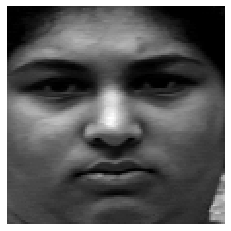

In [29]:
gen_emotionsFolders(
        main_dir=str('drive/MyDrive/AIHealthcare/Cohn_Kanade_Database/CK+/'),
        label_main_dir=str('drive/MyDrive/AIHealthcare/Cohn_Kanade_Database/CK+/Emotion/'),
        image_main_dir=str('drive/MyDrive/AIHealthcare/Cohn_Kanade_Database/CK+/cohn-kanade-images/'),
        emotions_dir=str('drive/MyDrive/AIHealthcare/Cohn_Kanade_Database/CK+/emotion_images/'),
        crop_faces=str(True),
        neutral_label=str(0),
        min_seq_len=int(9),
        depth=int(3),
        t_height=int(112),
        t_width=int(112))

In [ ]:
# ls 'drive/MyDrive/AIHealthcare/Cohn_Kanade_Database/CK+/Emotion'
# !python train.py drive/MyDrive/AIHealthcare/Cohn_Kanade_Database/CK+/emotion_images/  43 .1 .3 32 10

# Train model

In [32]:
import numpy as np
import os, sys, random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras import backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D
from keras.layers.normalization import BatchNormalization
from keras.engine.topology import get_source_inputs
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import optimizers

In [33]:
def recover_3darrays(emotions_dir, neutral_instances):
    """Generates a single X, y arrays using all Numpy binary file.

      Args:
        emotions_dir: String path to folder with emotion folders.
        neutral_instances: Number of neutral instances to add to the X, y 
            arrays. Given the high number of neutral instances that are
            generated, even with a low class weight in the training phase 
            the model will have a poor performance. A good choice can be 
            a number between 30 - 50.

      Returns:
        An array X with all 3D images on the dataset.
        An array y with the labels of all 3D images on the dataset.
    """

    labels = sorted(os.listdir(emotions_dir))

    for index1, label in enumerate(labels):
        if index1 == 0:
            print("Recovering arrays for label", label)
            for index2, npy in enumerate(
                    os.listdir(emotions_dir + label)[:neutral_instances]):
                im = np.load(emotions_dir + label + '/' + npy)
                if index1 == 0 and index2 == 0:
                    X = np.zeros((0, im.shape[0], im.shape[1], im.shape[2],
                                  im.shape[3]))
                    y = np.zeros((0, len(labels)))
                X = np.append(X, [im], axis=0)

                y_temp = [0] * len(labels)
                for index, lab in enumerate(labels):
                    if int(label) == int(lab):
                        y_temp[index] = 1.0
                        break
                y = np.append(y, [y_temp], axis=0)
        else:
            print("Recovering arrays for label", label)
            for index2, npy in enumerate(os.listdir(emotions_dir + label)):
                im = np.load(emotions_dir + label + '/' + npy)
                X = np.append(X, [im], axis=0)

                y_temp = [0] * len(labels)
                for index, lab in enumerate(labels):
                    if int(label) == int(lab):
                        y_temp[index] = 1.0
                        break
                y = np.append(y, [y_temp], axis=0)

    print("\nShape of X array:", X.shape)
    print("Shape of y array:", y.shape)
    return X, y

In [34]:
def train_test_valid_split(X, y, test_size, valid_size):
    """Generates the train, test and validation datasets.

      Args:
        X: Numpy array with all input images.
        y: Numpy array with all labels.
        test_size: Float percentage in the range (0, 1) of images
            used in test set.
        valid_size: Float percentage in the range (0, 1) of images
            used in validation set.
        
      Returns:
        Arrays of images and labels for each data partition. 
    """
    total_size = len(y)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size)
    train_size = len(y_train)
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=total_size * valid_size / train_size)
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [35]:
def create_model(input_tensor=None, input_shape=None, classes=7):
    """Creates C3D model with 3 more fully connected layers.

      Args:
        input_tensor: Tensor image to be processed
        input_shape: String tuple (height, width, channels) of input image
        classes: Integer number of classes
        
      Returns:
        Keras neural network model. 
    """

    K.set_image_data_format("channels_last")

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # Layer 1
    conv_1 = Convolution3D(
        64, (3, 3, 3),
        strides=(1, 1, 1),
        padding='same',
        activation='relu',
        name='conv_1',
        data_format="channels_last")(img_input)
    maxpool_1a = MaxPooling3D(
        (2, 2, 2), strides=(2, 2, 2), name="maxpool_1a",
        padding='same')(conv_1)
    batchnorm_1 = BatchNormalization(name="batchnorm_1")(maxpool_1a)

    # Layer 2
    conv_2 = Convolution3D(
        128, (3, 3, 3),
        strides=(1, 1, 1),
        padding='same',
        activation='relu',
        name='conv_2',
        data_format="channels_last")(batchnorm_1)
    maxpool_2 = MaxPooling3D(
        (2, 2, 2), strides=(2, 2, 2), name="maxpool_2", padding='same')(conv_2)

    # Layer 3
    conv_3 = Convolution3D(
        256, (3, 3, 3),
        strides=(1, 1, 1),
        padding='same',
        activation='relu',
        name='conv_3',
        data_format="channels_last")(maxpool_2)

    # Layer 4
    conv_4 = Convolution3D(
        256, (3, 3, 3),
        strides=(1, 1, 1),
        padding='same',
        activation='relu',
        name='conv_4',
        data_format="channels_last")(conv_3)
    maxpool_4 = MaxPooling3D(
        (2, 2, 2), strides=(2, 2, 2), name="maxpool_4", padding='same')(conv_4)

    # Layer 5
    conv_5 = Convolution3D(
        512, (3, 3, 3),
        strides=(1, 1, 1),
        padding='same',
        activation='relu',
        name='conv_5',
        data_format="channels_last")(maxpool_4)

    # Layer 6
    conv_6 = Convolution3D(
        512, (3, 3, 3),
        strides=(1, 1, 1),
        padding='same',
        activation='relu',
        name='conv_6',
        data_format="channels_last")(conv_5)
    maxpool_6 = MaxPooling3D(
        (2, 2, 2), strides=(2, 2, 2), name="maxpool_6", padding='same')(conv_6)

    # Layer 7
    conv_7 = Convolution3D(
        512, (3, 3, 3),
        strides=(1, 1, 1),
        padding='same',
        activation='relu',
        name='conv_7',
        data_format="channels_last")(maxpool_6)

    # Layer 8
    conv_8 = Convolution3D(
        512, (3, 3, 3),
        strides=(1, 1, 1),
        padding='same',
        activation='relu',
        name='conv_8',
        data_format="channels_last")(conv_7)
    maxpool_8 = MaxPooling3D(
        (2, 2, 2), strides=(2, 2, 2), name="maxpool_8", padding='same')(conv_8)

    flat = Flatten(name='flatten')(maxpool_6)
    fc_1 = Dense(4096, activation='relu', name='fc_1')(flat)
    dropout_1 = Dropout(0.33, name='dropout_1')(fc_1)
    net = Dense(classes, activation='softmax', name='predictions')(dropout_1)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = Model(inputs, net, name='MOC3D')

    for layer in model.layers:
        layer.trainable = True

    return model

Recovering arrays for label 0
Recovering arrays for label 1
Recovering arrays for label 2
Recovering arrays for label 3
Recovering arrays for label 4
Recovering arrays for label 5
Recovering arrays for label 6
Recovering arrays for label 7

Shape of X array: (359, 3, 112, 112, 3)
Shape of y array: (359, 8)
Class distribution: {0: 43, 1: 45, 2: 16, 3: 56, 4: 24, 5: 69, 6: 28, 7: 78}

  Training set =  (215, 3, 112, 112, 3)
Validation set =  (36, 3, 112, 112, 3)
      Test set =  (108, 3, 112, 112, 3)

Epoch 1/10
7/7 - 3s - loss: 17.9508 - accuracy: 0.1163 - val_loss: 1.9746 - val_accuracy: 0.1944
Epoch 2/10
7/7 - 2s - loss: 3.7582 - accuracy: 0.1209 - val_loss: 2.1701 - val_accuracy: 0.2778
Epoch 3/10
7/7 - 2s - loss: 3.6914 - accuracy: 0.1488 - val_loss: 2.0764 - val_accuracy: 0.1667
Epoch 4/10
7/7 - 2s - loss: 3.6720 - accuracy: 0.0930 - val_loss: 2.5788 - val_accuracy: 0.0833
Epoch 5/10
7/7 - 2s - loss: 3.6514 - accuracy: 0.1767 - val_loss: 2.0471 - val_accuracy: 0.1944
Epoch 6/10
7/

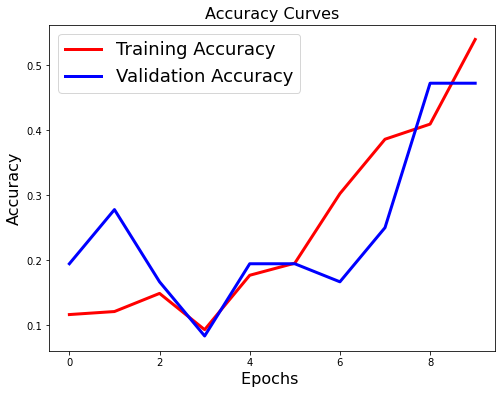


Saving model and weights...

Model and weights saved to disk.



In [38]:
emotions_dir = str('drive/MyDrive/AIHealthcare/Cohn_Kanade_Database/CK+/emotion_images/')
neutral_instances = int(43)
valid_split = float(.1)
test_split = float(.3)
batch_size = int(32)
epochs = int(10)

try:
    assert (valid_split + test_split < .9)
except AssertionError as e:
    print('Please check the validation and test set sizes.')
    raise

X, y = recover_3darrays(emotions_dir, neutral_instances=neutral_instances)

y_counts = np.sum(y, axis=0, dtype=np.int32)
keys = range(len(y_counts))
distrib = dict(zip(keys, y_counts))
print("Class distribution:", distrib)

X_train, y_train, X_valid, y_valid, X_test, y_test = \
                  train_test_valid_split(X, y, test_split, valid_split)

print("\n  Training set = ", str(X_train.shape))
print("Validation set = ", str(X_valid.shape))
print("      Test set = ", str(X_test.shape) + "\n")

y_sum = np.append(y_train, y_valid, axis=0)
y_count = np.sum(y_sum, axis=0, dtype=np.int32)
y_cnt = np.round(np.max(y_count) / y_count, 4)
keys = range(len(y_cnt))
class_weights = dict(zip(keys, y_cnt))

optimizer = "adam"
metrics = ['accuracy']
loss = 'categorical_crossentropy'

model = create_model(
    input_tensor=None, input_shape=X_train[0].shape, classes=len(keys))

model.compile(optimizer, loss, metrics)

reduce_lr = ReduceLROnPlateau(
    monitor='val_acc', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
early_stopping = EarlyStopping(
    monitor='val_acc',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='max',
    baseline=None)

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(X_valid, y_valid),
    class_weight=class_weights,
    callbacks=[reduce_lr])

scores = model.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (scores[1] * 100))

print("\nDisplaying accuracy curves...")

# Accuracy Curves
plt.figure(figsize=[8, 6])
plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)
plt.show()

print("\nSaving model and weights...")

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("weigths.h5")
print("\nModel and weights saved to disk.\n")

In [62]:
# print(X_test[0].shape)
# print(X_test[0][np.newaxis,:,:,:,:].shape)

(1, 3, 112, 112, 3)

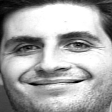

In [54]:
from google.colab.patches import cv2_imshow
cv2_imshow(X_test[0][0])         

In [45]:
# ls 'drive/MyDrive/AIHealthcare/CKPlus/CKPlus'
# !cp /content/weigths.h5 drive/MyDrive/AIHealthcare/CKPlus/CKPlus
# !cp /content/model.json drive/MyDrive/AIHealthcare/CKPlus/CKPlus

# Deploy

In [64]:
classau = model.predict(X_test[0][np.newaxis,:,:,:,:])

In [66]:
classau

array([[0.22141752, 0.08319061, 0.00188459, 0.03990152, 0.10450736,
        0.4555263 , 0.07176475, 0.02180732]], dtype=float32)

5

In [96]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(["01_neutral", "02_anger", "03_contempt", "04_disgust", "05_fear", "06_happy", "07_sadness", "08_surprise"])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'01_neutral': 0, '02_anger': 1, '03_contempt': 2, '04_disgust': 3, '05_fear': 4, '06_happy': 5, '07_sadness': 6, '08_surprise': 7}


In [101]:
list(le.inverse_transform([np.argmax(classau)]))[0]

'06_happy'